<a href="https://colab.research.google.com/github/girotomas/AppDrawrer/blob/master/PS6_Tomas.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 6


### Part 1

In [0]:
from pandas import *
from numpy import *
from matplotlib.pyplot import *
import os
from scipy.stats import t as student
from IPython.display import Markdown
import numpy as np

import wrds
db = wrds.Connection(wrds_username = 'vtissot')
db.create_pgpass_file()

# Load and clean the data:

data = db.raw_sql("select  a.permno,a.date, a.ret, a.prc, a.shrout , b.shrcd, b.exchcd\
                    from crsp.msf as a left join crsp.msenames \
                    as b on a.permno = b.permno and b.namedt <= a.date\
                    where a.date >='1970-01-01' and a.date <='2018-12-31'\
                    and  b.shrcd in (10,11) and   b.exchcd in (1,2) ")

In [3]:
# Load the Drive helper and mount
from google.colab import drive

# This will prompt for authorization.
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


In [6]:
# files will be present in "/content/drive/My Drive".
!ls "/content/drive/My Drive/Cours EPFL/Investments"

CRSP_cleaned.csv  PS6_Tomas.ipynb  Tbill.csv  VW_CRSP.csv


In [0]:
# Load the data:

# Tbill:
Tbill = read_csv('/content/drive/My Drive/Cours EPFL/Investments/Tbill.csv',index_col = 0)

# Value-weighted index returns:
VW_CRSP = read_csv('/content/drive/My Drive/Cours EPFL/Investments/VW_CRSP.csv',index_col = 0)

# Stocks:
CRSP_data = read_csv('/content/drive/My Drive/Cours EPFL/Investments/CRSP_cleaned.csv',index_col = 0)

### Part 2

In [10]:
# set the same dates for the market return series:

L = len(CRSP_data['permno'])

DATES = Index(sorted(set(CRSP_data.index)))

VW_CRSP = VW_CRSP.set_index(DATES)

# Add the market return into the data frame:

CRSP_data['Market'] = empty((L,1))

for d in DATES:
    CRSP_data['Market'].loc[d] = float(VW_CRSP.loc[d].values)

display(CRSP_data.head())

,permno,return,price,shares outstanding,Market
date,,,,,
2009-12-31,10001.0,0.162621,10.3000,4361.0,0.028430
2010-01-29,10001.0,-0.018932,10.0600,4361.0,-0.037098
2010-02-26,10001.0,-0.000656,10.0084,4361.0,0.034786
2010-03-31,10001.0,0.020643,10.1700,4361.0,0.063626
2010-04-30,10001.0,0.124385,11.3900,6070.0,0.020063


In [11]:
# Compute the betas:

CRSP_data['beta'] = empty((L,1))

permno = sorted(list(set(CRSP_data['permno'])))

variance = CRSP_data.groupby(['permno'])['Market'].var()

for p in permno:
    
    cov = CRSP_data['return'].loc[CRSP_data['permno'] == p]\
         .cov(CRSP_data['Market'].loc[CRSP_data['permno'] == p])

    #variance  = CRSP_data['Market'].loc[CRSP_data['permno'] == p].var()

    CRSP_data['beta'].loc[CRSP_data['permno'] == p] = cov/variance.loc[p]
    
display(CRSP_data.tail(10))

,permno,return,price,shares outstanding,Market,beta
date,,,,,,
2018-03-29,93426.0,0.040067,31.150000,12402.0,-0.018433,0.992034
2018-04-30,93426.0,-0.091493,28.299999,12423.0,0.004769,0.992034
2018-05-31,93426.0,0.326855,37.549999,12429.0,0.026170,0.992034
2018-06-29,93426.0,0.015979,38.150002,12429.0,0.005334,0.992034
2018-07-31,93426.0,0.045872,39.900002,12429.0,0.031605,0.992034
2018-08-31,93426.0,0.085213,43.299999,12449.0,0.030221,0.992034
2018-09-28,93426.0,-0.136259,37.400002,12449.0,0.000443,0.992034
2018-10-31,93426.0,-0.132353,32.450001,12449.0,-0.074031,0.992034
2018-11-30,93426.0,0.045609,33.930000,12449.0,0.018530,0.992034


In [12]:
# Portfolios for each deciles:
CRSP_data['decile']= empty((L,1))

for date in DATES:
    CRSP_data['decile'].loc[date] = qcut(CRSP_data['beta'].loc[date], 10, labels=range(10))
    
info = CRSP_data.groupby('decile').mean()

display(info)

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


,permno,return,price,shares outstanding,Market,beta
decile,,,,,,
0,43124.124008,0.010114,27.919057,90473.556458,0.008392,0.366386
1,44099.222821,0.011089,401.600878,196265.627787,0.008384,0.642808
2,45516.330085,0.011358,44.473612,159898.064490,0.008399,0.801042
3,45687.022680,0.011023,31.676119,115615.149005,0.008391,0.928695
4,43214.507926,0.011764,30.915042,93073.337720,0.008397,1.036215
5,42028.389228,0.010858,30.438060,129341.093852,0.008387,1.138235
6,45123.558190,0.011609,27.734158,119225.884298,0.008410,1.244133
7,48634.549373,0.010864,26.745871,147629.904859,0.008375,1.366953
8,50552.658328,0.011349,22.216071,116202.720567,0.008394,1.558517


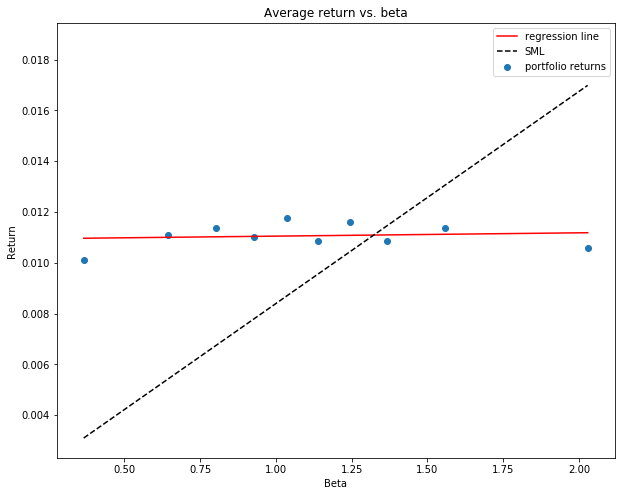

In [13]:
# Create a function to plot the result:

def plot_CAPM(X,Y, myTitle='Average return vs. beta'): 
    '''X: betas, Y: return'''

    figure(figsize=(10,8))

    scatter(X,Y,label = 'portfolio returns')

    plot(X, poly1d(polyfit(X, Y, 1))(X),'r',label = 'regression line')

    # Security Market Line

    # average return on the market:
    mu_M = CRSP_data['Market'].mean()

    # Risk free rate:
    
    R_0  = float(Tbill.mean()/100)

    grid = linspace(min(X),max(X),50)

    SML  = R_0 +  grid * (mu_M - R_0)

    plot(grid,SML,'--k',label = 'SML')

    title(myTitle)
    xlabel('Beta')
    ylabel('Return')
    legend()
    show()

# scatter plot and regression line

plot_CAPM(info['beta'],info['return'])


*Compare the slope of the regression line to that of the average excess return on the market:*

We can observe that the slope of the regression line is a lot less steep than the one for the excess return on the market. This result is coherent with the research that we have seen in the lecture. It might be because most market participants cannot really borrow at the Tbill rate.

### Part 3


In [14]:
# We create a function:

def High_minus_Low_Beta_Performance(Returns_decile):
    
    Returns_High_minus_Low_Beta =  Returns_decile.loc[9] - Returns_decile.loc[0]
    # average return:
    Mu_High_minus_Low_Beta  =  Returns_High_minus_Low_Beta.mean()

    # standard deviation
    Std_High_minus_Low_Beta =  Returns_High_minus_Low_Beta.std()

    # t-statistic:

    T = Returns_High_minus_Low_Beta.count()

    t = Mu_High_minus_Low_Beta / (Std_High_minus_Low_Beta/sqrt(T))

    p_value = 1 - ( student.cdf(t, T-1) - 0.5 ) * 2

    display(DataFrame([[Mu_High_minus_Low_Beta,Std_High_minus_Low_Beta,t, p_value]],
                      columns = ['Return','Standard deviation','t-statistic', 'p-value'],
                      index = Index(['High minus Low Beta Strategy']) ))

    
# Compute the EW monthly return for each portfolio

Returns_decile = CRSP_data.groupby(['decile','date'])['return'].mean()
display(DataFrame(Returns_decile).head(10))

# Call the above function
print('Equally weighted betting on forward looking beta performance:')
High_minus_Low_Beta_Performance(Returns_decile)

return
decile date                
0      1970-01-30 -0.010733
       1970-02-27  0.039031
       1970-03-31  0.021486
       1970-04-30 -0.083593
       1970-05-29 -0.057287
       1970-06-30 -0.026253
       1970-07-31  0.044145
       1970-08-31  0.030731
       1970-09-30  0.037204
       1970-10-30 -0.000691

Equally weighted betting on forward looking beta performance:


,Return,Standard deviation,t-statistic,p-value
High minus Low Beta Strategy,0.001034,0.084966,0.295209,0.767939


*Is  the  return  statistically  significantly  different  from zero?*
The p-value from the T-statistic of the two sided test for mu=0 (H0) is 0.77. The evidence is not significant against the returns being zero.

This evidence does not look consistent with the CAPM. One would expect that this strategy gave a positive return, because the CAPM predicts higher returns for higher beta stocks.

### Part 4

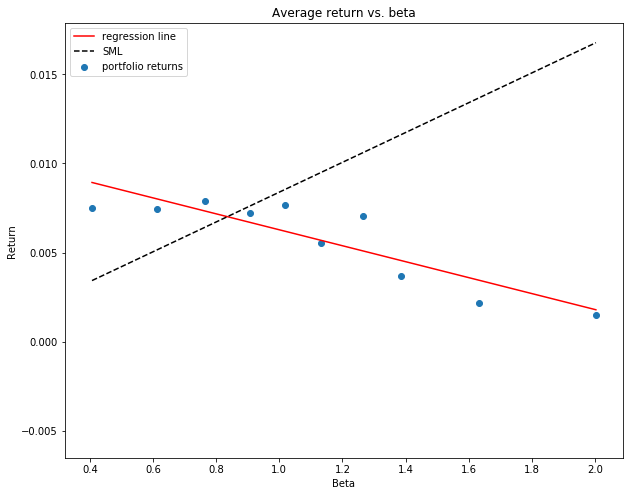

,VW return,VW beta
decile,,
0,0.007502,0.406801
1,0.007452,0.611249
2,0.007905,0.764205
3,0.007221,0.906023
4,0.007698,1.019615
5,0.005564,1.133643
6,0.007043,1.265258
7,0.003689,1.385063
8,0.002206,1.633719


In [15]:
# Market capitalization 

CRSP_data['Market cap'] =  (CRSP_data['price'] *\
                                        CRSP_data['shares outstanding'])

# MCAP-value-weighting betas and returns:

def VW_average(group, name, weight):                                
    ''' description: group takes the decile group, name is the name of the statistic to be
        computed and weight is how to weight (Market Cap) 
        
        usage:  CRSP_data.groupby(['decile']).apply(VW_average,'return','Market cap')'''
    
    d = group[name]
    
    # For the VW return, use the market cap of the previous month:
    if name == 'return':
        w = group[weight].shift(1)
    else:
        w = group[weight]
    try:
        return (d * w).sum() / w.sum()
    
    except ZeroDivisionError:
        
        return nan
    
info_VW = DataFrame()

# Value-weigthed returns:
info_VW['VW return'] = CRSP_data.groupby('decile').apply(VW_average,'return','Market cap')
info_VW['VW beta']   = CRSP_data.groupby('decile').apply(VW_average,'beta','Market cap')

plot_CAPM(info_VW['VW beta'], info_VW['VW return'])

display(info_VW.head(10))


In [16]:
# VW performance:

Return_decile_VW = CRSP_data.groupby(['decile','date']).apply(VW_average,'return','Market cap')

# Call the function to print the t-statistic of the test:
# H0: HML (High Minus Low beta) strategy has a zero mean return.
print('Value weighted betting on forward looking beta performance:')
High_minus_Low_Beta_Performance(Return_decile_VW )

Value weighted betting on forward looking beta performance:


,Return,Standard deviation,t-statistic,p-value
High minus Low Beta Strategy,0.002244,0.075834,0.7177,0.473228


### Part 5
#### *We  would  like  to  have  a  test  that does not suffer from look ahead bias*

In [17]:
# Compute the no-look-ahead betas:

CRSP_data['beta no look ahead'] = empty((L,1))

permno = sorted(list(set(CRSP_data['permno'])))

variance_no_look_ahead = CRSP_data.groupby(['permno'])['Market'].rolling(24).var()

for p in permno:
    
    cov = CRSP_data['return']\
    .loc[CRSP_data['permno'] == p].rolling(24)\
         .cov( CRSP_data['Market']\
    .loc[CRSP_data['permno'] == p]) #    <---  

    CRSP_data['beta no look ahead'].loc[CRSP_data['permno'] == p] = cov/variance_no_look_ahead.loc[p]
    


/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


In [18]:
# every month form decile portfolios based on these betas estimated from past data
# compute the average returns of these decile portfolios

CRSP_data['decile no look ahead']= empty((L,1))

for date in DATES:
    CRSP_data['decile no look ahead'].loc[date] = qcut(CRSP_data['beta no look ahead']\
                                                       .loc[date], 10, labels=range(10))
    
info_no_look_ahead = CRSP_data.groupby('decile no look ahead').mean()



/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


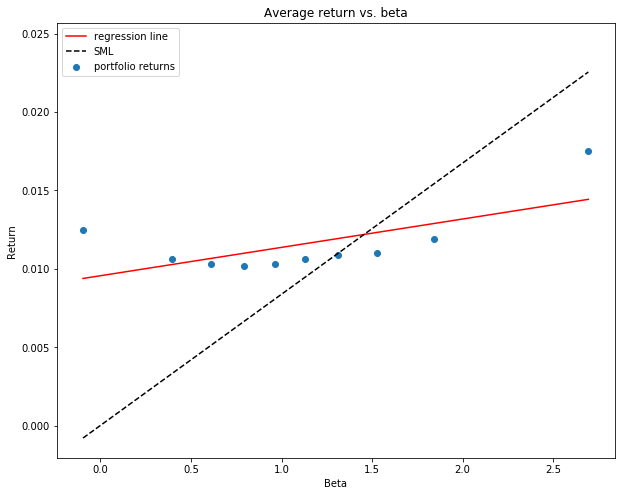

In [19]:
# Plot the average return to these‘out-of-sample-beta’ decile portfolios versus their average beta

plot_CAPM(info_no_look_ahead['beta no look ahead'] , # average betas not forward looking betas
          info_no_look_ahead['return'] ) # expected returns

In [20]:
# compute the average and standard error of the return to a long-short strategy
# that goes long the high-beta decile and shorts the low-beta decile portfolio


# Compute the EW monthly return for each portfolio of the not forward looking type
# (this is done by using the 'decile no look ahead' deciles)

Returns_decile = CRSP_data.groupby(['decile no look ahead','date'])['return'].mean()

# Call the function to compute the statistics
print('Equally weighted betting on predicted beta performance:')
High_minus_Low_Beta_Performance(Returns_decile)

Equally weighted betting on predicted beta performance:


,Return,Standard deviation,t-statistic,p-value
High minus Low Beta Strategy,0.005558,0.130185,1.035295,0.300958


In [0]:
#  Is the return to this strategy statistically different from zero ?

We would expect if the CAPM holds, the return from this strategy to be different from zero. But we cannot 
discard the hypothesis that this return is 0 there is not strong evidence against it. So the return
is not statistically different from zero.

In [0]:
# Compare  equal-weighting  and value-weighting

#### We calculated the equal-weighting results with the no forward looking betas. Let's calculate the value-weighted returns.

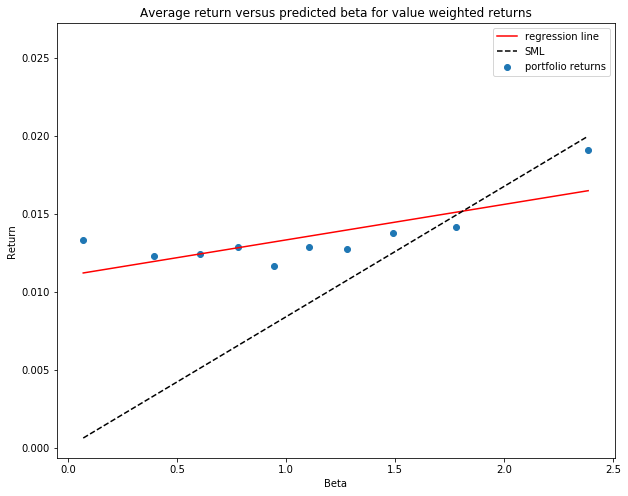

,VW return,VW beta no look ahead
decile no look ahead,,
0.0,0.013337,0.069785
1.0,0.012311,0.394937
2.0,0.012387,0.604264
3.0,0.012845,0.780966
4.0,0.011618,0.945310
5.0,0.012877,1.106621
6.0,0.012759,1.279952
7.0,0.013740,1.491535
8.0,0.014175,1.781215


In [23]:
# SHOULD WE BE PLOTTING AGAINST PREDICTED BETA OR REALIZED BETA????

info_VW_no_look_ahead = DataFrame()

# Value-weigthed returns:
info_VW_no_look_ahead['VW return'] = CRSP_data.groupby(['decile no look ahead','date']).apply(VW_average,'return','Market cap').groupby('decile no look ahead').mean()
info_VW_no_look_ahead['VW beta no look ahead']   = CRSP_data.groupby(['decile no look ahead','date']).apply(VW_average,'beta no look ahead','Market cap').groupby('decile no look ahead').mean()

plot_CAPM(info_VW_no_look_ahead['VW beta no look ahead'], info_VW_no_look_ahead['VW return'],
         'Average return versus predicted beta for value weighted returns')
display(info_VW_no_look_ahead)


For the value weighted, non forward looking beta the regression line is negative.

In [24]:
# VW performance:

Return_decile_VW_no_look_ahead = CRSP_data.groupby(['decile no look ahead', 'date']).apply(VW_average,'return','Market cap')

# Call the function to print the t-statistic of the test:
# H0: HML (High Minus Low beta) strategy has a zero mean return.
display(Markdown('**Value of the value weighted betting on predicted beta performance:**'))
High_minus_Low_Beta_Performance(Return_decile_VW_no_look_ahead )


**Value of the value weighted betting on predicted beta performance:**

,Return,Standard deviation,t-statistic,p-value
High minus Low Beta Strategy,0.005729,0.11952,1.162253,0.245605


### Part 6

*Note that the Fama-McBeth procedure discussed in class, is very similar to the portfolio sorting procedure we just implemented.  Explain how you would implement the Fama-McBeth approach and how it would differ from the approach wehave used in this exercise.*

The Fama McBeth approach would consist in a first rolling regression of the returns on the market return. 
And then a second cross-sectional regression on each specific date of the returns of the stocks on their 
betas to obtain the excess return from their exposure to the market. Then the lambda (market exposure risk premium) would be averaged across time to see if it was statistically significant from 0.

Here we made a statistical significance test on the mean return of a given strategy. The Fama McBeth approach can also be interpreted as a statistical significance test on the mean return of a given strategy. The difference is that in this exercise the weights of the trading strategy are one for the highest beta decile and -1 for the lowest beta decile. Whereas in the Fama McBeth approach the weights of the trading strategy are linerarly correlated to the rolling beta predicted at each specific point in time.

### Part 7

*We will now investigate size portfolios.  In each month, sort stocks into 10 decile portfolios based on their market capitalization in the previous month.*

In [25]:
# DUPLICATE DATA?????????
CRSP_data.iloc[0:10000][['return', 'permno']].sort_values(by=['permno', 'date']).groupby(['permno','date']).count()

return
permno  date              
10001.0 2009-12-31       1
        2010-01-29       1
        2010-02-26       1
        2010-03-31       1
        2010-04-30       1
        2010-05-28       1
        2010-06-30       1
        2010-07-30       2
        2010-08-31       2
        2010-09-30       2
        2010-10-29       2
        2010-11-30       2
        2010-12-31       2
        2011-01-31       2
        2011-02-28       2
        2011-03-31       2
        2011-04-29       2
        2011-05-31       2
        2011-06-30       2
        2011-07-29       2
        2011-08-31       2
        2011-09-30       2
        2011-10-31       2
        2011-11-30       2
        2011-12-30       2
        2012-01-31       2
        2012-02-29       2
        2012-03-30       2
        2012-04-30       2
        2012-05-31       2
...                    ...
10137.0 2008-09-30       3
        2008-10-31       3
        2008-11-28       3
        2008-12-31       3
        2009-01-30       3
        2009-02-27       3
        2009-03-31       3
        2009-04-30       3
        2009-05-29       3
        2009-06-30       3
        2009-07-31       3
        2009-08-31       3
        2009-09-30       3
        2009-10-30       3
        2009-11-30       3
        2009-12-31       3
        2010-01-29       3
        2010-02-26       3
        2010-03-31       3
        2010-04-30       3
        2010-05-28       3
        2010-06-30       3
        2010-07-30       3
        2010-08-31       3
        2010-09-30       3
        2010-10-29       3
        2010-11-30       3
        2010-12-31       3
        2011-01-31       3
        2011-02-28       0

[3574 rows x 1 columns]

In [0]:
# We define CRSP2 reseting the indexes from CRSP_data.
CRSP2=CRSP_data.reset_index()

In [0]:
#We remove the duplicates
CRSP2=CRSP2.loc[CRSP2[['date','permno']].drop_duplicates().index]

In [0]:
# We create the 'previous Market cap' column 
CRSP2['previous Market cap']=CRSP2['Market cap'].shift(1)

# We delete the first previous market cap value for all stocks because it is unknown
CRSP2.loc[CRSP2['permno'].drop_duplicates().index, 'previous Market cap']=np.nan

In [0]:
# every month form decile portfolios based on the size of the stocks traded.


CRSP2['decile SML']= np.nan  # SML stands for Small minus Large !


for date in DATES[1:]:
    CRSP2.loc[CRSP2['date']==date, 'decile SML'] = qcut(CRSP2\
             .loc[CRSP2['date']==date]['previous Market cap'], 10, labels=range(10))
    




In [30]:
# compute the average returns, volatility and Sharpe ratios of these decile portfolios
group_by_decile=CRSP2[['return','decile SML']].groupby('decile SML')


info_SML=concat([group_by_decile.mean(), 
                 group_by_decile.std(),
                 (group_by_decile.mean()-Tbill.mean()[0])/group_by_decile.std()],
                 axis=1)
info_SML.columns=['return','volatility','sharpe ratio']
info_SML

,return,volatility,sharpe ratio
decile SML,,,
0.0,0.018151,0.241294,0.059623
1.0,0.009172,0.190311,0.028417
2.0,0.009568,0.162236,0.035771
3.0,0.011204,0.146437,0.050808
4.0,0.011318,0.134390,0.056204
5.0,0.011710,0.125504,0.063308
6.0,0.011396,0.112862,0.067619
7.0,0.010941,0.103075,0.069628
8.0,0.010630,0.096227,0.071345


*Plot average return, volatility and Sharpe ratio of the 10-size sorted portfolios.  Is a longshort strategy of Smallest decile minus Biggest decile stocks profitable?*

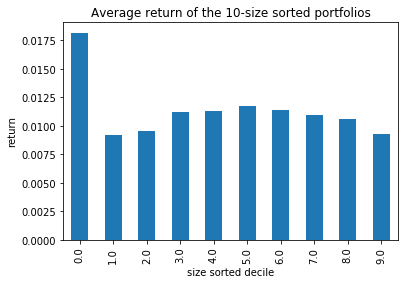

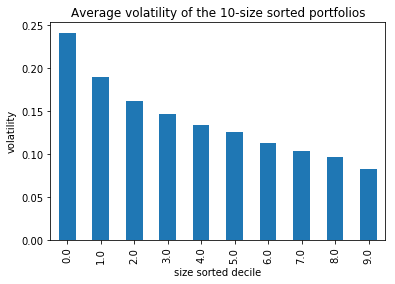

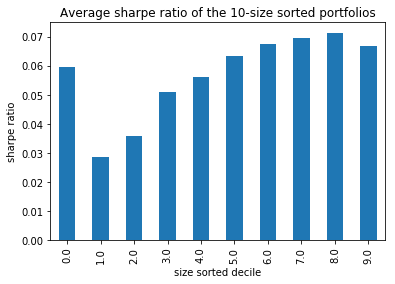

In [31]:
for i in info_SML.columns:
    info_SML[i].plot(kind='bar')
    title('Average '+i+' of the 10-size sorted portfolios')
    ylabel(i)
    xlabel('size sorted decile')
    show()

In [88]:
def Compute_Performance(Returns_decile, ttype, strategy_name, myDisplay=True):
    '''ttype : defines if the strategy should be short decile 0 or long decile 0.
    returns decile: is the return indexed by deciles first then date
    strategy name: the name of the strategy to display'''
    
    assert ttype in ['9-0','0-9', '4-0', '0-4'], 'ttype must be "9-0", "0-9", "4-0" or "0-4".'
    if ttype=='0-9': Returns_Small_minus_Large =  Returns_decile.loc[0] - Returns_decile.loc[9]
    if ttype=='9-0': Returns_Small_minus_Large =  Returns_decile.loc[9] - Returns_decile.loc[0]
    if ttype=='4-0': Returns_Small_minus_Large =  Returns_decile.loc[4] - Returns_decile.loc[0]
    if ttype=='0-4': Returns_Small_minus_Large =  Returns_decile.loc[0] - Returns_decile.loc[4]

    # average return:
    Mu_Small_minus_Large  =  Returns_Small_minus_Large.mean()

    # standard deviation
    Std_Small_minus_Large =  Returns_Small_minus_Large.std()
    
    # Sharpe ratio
    Sharpe_ratio = ( Mu_Small_minus_Large - Tbill.mean()[0] ) / Std_Small_minus_Large
    
    
    
    # t-statistic:

    T = Returns_Small_minus_Large.count()

    t = Mu_Small_minus_Large / (Std_Small_minus_Large/sqrt(T))

    p_value = 1 - ( student.cdf(abs(t), T-1) - 0.5 ) * 2

    
    
    result= (DataFrame([[Mu_Small_minus_Large, Std_Small_minus_Large, Sharpe_ratio, t, p_value]],
                      columns = ['Return','Standard deviation','Sharpe ratio','t-statistic', 'p-value'],
                      index = Index([strategy_name]) ))
    if(myDisplay): (display(result))
    return(result)
  
  
Compute_Performance(CRSP2[['return','decile SML','date']].groupby(['decile SML','date'])['return'].mean(),
                             ttype='0-9',
                             strategy_name='Small minus Large Strategy')

,Return,Standard deviation,Sharpe ratio,t-statistic,p-value
Small minus Large Strategy,0.008748,0.067032,0.074351,3.161936,0.001648


,Return,Standard deviation,Sharpe ratio,t-statistic,p-value
Small minus Large Strategy,0.008748,0.067032,0.074351,3.161936,0.001648


A longshort strategy of Smallest decile minus the Biggest decile stocks is profitable. The p-value associated to nullity test indicates that at 95% of the cases it is profitable. GRAPH VALUE AT 0 DECILE STRANGE

### Part 8

We now want to understand whether this is driven by differences in betas.  Compute the average beta of the 10 size-sorted portfolios by regressing the portfolio excess returns on the market excess returns for the whole sample period.

In [0]:
Tbill2=Tbill.copy()
Tbill2.columns=['date', 'r0']
CRSP2=CRSP2.merge(Tbill2, on='date')

$\text{Excess return}_{\text{decile}}=\alpha_d + \beta_d r_M$

In [43]:
beta_EW=[] #EW -> equally weighted
for decile in range(10):
    # excess return for the decile indexed by date
    group=CRSP2.loc[CRSP2['decile SML']==decile].groupby(['date']).mean()
    returns=group['return'] # mean over a constant
    r0=group['r0']
    excess_return=returns-r0
    market=group['Market']
    beta_EW+=[Series(excess_return).cov(Series(market))/np.var(market)]
    
info_SML['beta EW']=beta_EW
info_SML

,return,volatility,sharpe ratio,beta EW
decile SML,,,,
0.0,0.018151,0.241294,0.059623,1.035551
1.0,0.009172,0.190311,0.028417,1.157830
2.0,0.009568,0.162236,0.035771,1.200706
3.0,0.011204,0.146437,0.050808,1.219304
4.0,0.011318,0.134390,0.056204,1.226323
5.0,0.011710,0.125504,0.063308,1.190206
6.0,0.011396,0.112862,0.067619,1.120979
7.0,0.010941,0.103075,0.069628,1.074462
8.0,0.010630,0.096227,0.071345,1.038592


In [44]:
beta_VW=[]
for decile in range(10):
    # excess return for the decile indexed by date
    group=CRSP2.loc[CRSP2['decile SML']==decile].groupby(['date'])
    returns=group.apply(VW_average,'return', 'previous Market cap')
    r0=group.apply(VW_average,'r0', 'previous Market cap') # VW mean over a constant
    excess_return=returns-r0
    market=group.apply(VW_average,'Market', 'previous Market cap')
    beta_VW+=[Series(excess_return).cov(Series(market))/np.var(market)]

info_SML['beta VW']=beta_VW
info_SML

,return,volatility,sharpe ratio,beta EW,beta VW
decile SML,,,,,
0.0,0.018151,0.241294,0.059623,1.035551,-1.182793
1.0,0.009172,0.190311,0.028417,1.157830,1.163730
2.0,0.009568,0.162236,0.035771,1.200706,1.191003
3.0,0.011204,0.146437,0.050808,1.219304,1.215720
4.0,0.011318,0.134390,0.056204,1.226323,1.220658
5.0,0.011710,0.125504,0.063308,1.190206,1.184383
6.0,0.011396,0.112862,0.067619,1.120979,1.116449
7.0,0.010941,0.103075,0.069628,1.074462,1.069961
8.0,0.010630,0.096227,0.071345,1.038592,1.033237


Plot the average return for size-sorted portfolios versus their betas.  Compare equal-weighted returns and value-weighted returns.  What do you conclude?

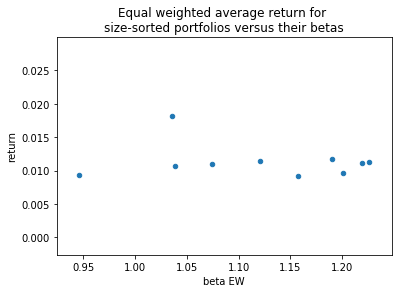

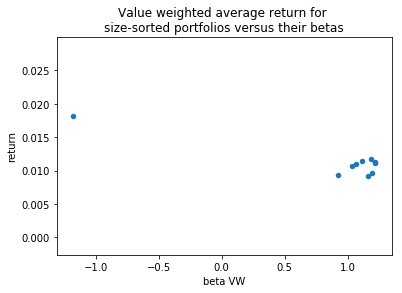

In [45]:
info_SML.plot('beta EW','return', kind='scatter')
title('Equal weighted average return for \nsize-sorted portfolios versus their betas')
show()

info_SML.plot('beta VW','return', kind='scatter')
title('Value weighted average return for \nsize-sorted portfolios versus their betas')
show()

CONCLUDE

### Part 9

*In order to better understand the different behavior of the different types of stocks, now construct double-sorted portfolios.*

*First, sort stocks in each month based on their lagged  market  capitalization  in to  5  quintiles.* 


In [0]:
for date in DATES[1:]: # We don't take the first date because the previous market cap. is unknown !
                        # for all stocks
    CRSP2.loc[CRSP2['date']==date,'size quintile']=\
        qcut(CRSP2.loc[CRSP2['date']==date]['previous Market cap'],\
             5, labels=range(5))


*Then  for  each  month  and size quintile, sort stocks based on their CAPM beta into 5 quintiles.*

In [0]:
#Takes a long time

# We create 'beta quintile 1'
for quintile in range(5):
    for date in DATES[1:]:
        # We use a try catch block because when all betas are Nan, the qcut raises an error
            try: CRSP2.loc[ (CRSP2['date']==date) & (CRSP2['size quintile']==quintile),'beta quintile']\
                = qcut( CRSP2.loc[ (CRSP2['date']==date) &  (CRSP2['size quintile']==quintile) ]\
                       ['beta'], 5, labels=range(5))
            except ValueError:
                pass

*Use again(a)  the  whole  sample  and  (b)  a  2-year  rolling  window  when  calculating  betas.*

In [0]:
# We create 'beta quintile 2'
for quintile in range(5):
    for date in DATES[1:]:
        # We use a try catch block because when all betas are Nan, the qcut raises an error
            try: CRSP2.loc[ (CRSP2['date']==date) & (CRSP2['size quintile']==quintile),'beta quintile no look']\
                = qcut( CRSP2.loc[ (CRSP2['date']==date) &  (CRSP2['size quintile']==quintile) ]\
                       ['beta no look ahead'], 5, labels=range(5))
            except ValueError:
                pass

*Compute the returns of a long-short strategy for each size quintile that buys the quintile of the high-beta stocks and sells the quintile of the low-beta stocks. What are the mean returns, volatilities and Sharpe ratios of the long-short portfolios?*

In [94]:
beta_types=['full time series beta', 'rolling window beta']
beta_codes=['beta quintile', 'beta quintile no look']


for i in range(2):
  result=[]
  for size_q in range(5):
    result+=[Compute_Performance( 
        (CRSP2.loc[CRSP2['size quintile']==size_q])\
        .groupby([beta_codes[i], 'date']).mean()['return']
        , '4-0', 
        str(size_q),
        myDisplay=False
    )]
  print('High minus low beta strategy by size quintile, using '+beta_types[i])
  res=concat(result)
  res.index.name = 'size quintile'
  display(res)
  print('\n\n')



High minus low beta strategy by size quintile, using full time series beta


,Return,Standard deviation,Sharpe ratio,t-statistic,p-value
size quintile,,,,,
0,0.005729,0.097529,0.020143,1.423146,0.155226
1,0.001780,0.071455,-0.027769,0.603563,0.546368
2,-0.000667,0.063663,-0.069598,-0.253651,0.799854
3,-0.002020,0.060188,-0.096102,-0.813093,0.416495
4,-0.002165,0.054441,-0.108920,-0.963695,0.335596





High minus low beta strategy by size quintile, using rolling window beta


,Return,Standard deviation,Sharpe ratio,t-statistic,p-value
size quintile,,,,,
0,0.011376,0.153469,0.049596,1.761902,0.078628
1,0.004631,0.113743,0.007624,0.967875,0.333522
2,0.001287,0.096933,-0.025558,0.315559,0.752454
3,-0.001477,0.083960,-0.062421,-0.418046,0.676072
4,-0.001792,0.077248,-0.071929,-0.562074,0.574280


*Plot the returns against their CAPM betas.  How do the mean returns compare to the CAPM-predicted returns (keep in mind that you are dealing with excess returns now when predicting returns with the CAPM)? Do your analysis for value-weighted returns, equally weighted returns as well as for a beta calculation based on the whole sample and based on a 2-year rolling window. Are your results consistent with your findings above on the different behavior of value-weighted vs.  equally weighted returns?*

In [96]:
def compute_beta(dataframe):
  ''' dataframe : must have "return", "Market", and "r0" and be indexed by dates '''
  excess_returns = dataframe['return']- dataframe['r0']
  return excess_returns.cov(dataframe['Market']) / var(dataframe['Market'])


# compute the betas
betas = []
for size_q in range(5):
    betas += [compute_beta( 
        CRSP2.loc[CRSP2['size quintile']==size_q]\
        .groupby(['date']).mean()
    )]
betas

[1.0968297943393088,
 1.2095045290006374,
 1.2084078443888622,
 1.0973043993988074,
 0.9914803591634974]